# efficiency.ipynb
This notebook reads in timing information from Parallel SnowModel output files executed using different domains

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from sklearn.linear_model import LinearRegression

## Functions

In [2]:
def get_parameter_float(stringtofind,parpath):
    """
        Gets float values from Parallel SnowModel output file.
        Parameters
        ----------
        stringtofind : string object that is searched in output file.
        stringtofind : string object of relative file path for output file.

        Returns
        -------
        var : float object of variable in output file.
    """
    with open(parpath) as f:
        for line in f:
            li = line.strip()
            if not li.startswith("!"):
                if stringtofind in li:
                    blah = li.replace(" ","")
                    var = float(blah.split(":",1)[1])
                    f.close()
                    return var

In [3]:
def get_parameter_int(stringtofind,parpath):
    """
        Gets integer values from Parallel SnowModel output file.
        Parameters
        ----------
        stringtofind : string object that is searched in output file.
        stringtofind : string object of relative file path for output file.

        Returns
        -------
        var : integer object of variable in output file.
    """
    with open(parpath) as f:
        for line in f:
            li = line.strip()
            if not li.startswith("!"):
                if stringtofind in li:
                    blah = li.replace(" ","")
                    var = int(blah.split("=",1)[1])
                    f.close()
                    return var

In [4]:
def speedup(df):
    """
        Calculate rel_speedup, approx_speedup, rel_efficiency, and approx_efficiency.
        Parameters
        ----------
        df : pandas dataframe containing execution time as function of the number of processes.

        Returns
        -------
        df : original pandas dataframe with added columns of rel_speedup, approx_speedup, rel_efficiency, and approx_efficiency.
    """

    min_proc = df.num_proc.min()
    serial_t = df[df['num_proc'] == min_proc]['total'].values    
    ## calculate speedup ##
    df['rel_speedup'] = serial_t / df['total']
    df['approx_speedup'] = (serial_t / df['total']) * min_proc
    ## calculate efficiency ##
    df['rel_efficiency'] = (df['rel_speedup'] / df['num_proc']) * 100
    df['approx_efficiency'] = (df['approx_speedup'] / df['num_proc']) * 100
    df.sort_values(by = 'num_proc',inplace = True)
    
    return df

In [5]:
def interp(df,effic):
    """
        Performs 1D interpolation at desired level of efficiency.
        Parameters
        ----------
        df : pandas dataframe containing execution time as function of the number of processes.
        effic : integer object representing desired level of efficiency

        Returns
        -------
        f : float of number of processes at desired level of efficiency
    """
    try:
        f = interpolate.interp1d(x = df.approx_efficiency, y = df.num_proc)
        return float(f(effic))
    except:
        return df['num_proc'].max()

In [6]:
def efficiency_v_ny(efficiency,df_tu,df_co,df_id,df_pnw,df_west,df_conus,num_ny):
    """
        Plots N vs. Ny and N vs l_ny at interpolated efficiency.
        Parameters
        ----------
        efficiency : float of desired level of efficiency.
        df_tu : pandas Tuolumne dataframe.
        df_co : pandas Tuolumne dataframe.
        df_id : pandas Tuolumne dataframe.
        df_pnw : pandas Tuolumne dataframe.
        df_west : pandas Tuolumne dataframe.
        df_conus : pandas Tuolumne dataframe.
        num_ny : list of global ny values for domain.
        PlotLinReg : Boolean to plot OLS Regression

        Returns
        -------
        f : float of number of processes at desired level of efficiency
    """
    ## constants ##
    marker_lst = ['x','|','^','D','s','o']
    color_lst = ['#CC6677','#332288','black','#FD5006','#AA4499','#317633']
    label_lst = ['Tuolumne','CO Headwaters','Idaho','PNW','Western US','CONUS']
    ## interpolate at given efficiency ##
    tu_eff = interp(df_tu,efficiency)
    co_eff = interp(df_co,efficiency)
    id_eff = interp(df_id,efficiency)
    pnw_eff = interp(df_pnw,efficiency)
    west_eff = interp(df_west,efficiency)
    conus_eff = interp(df_conus,efficiency)
    
    eff_proc = [tu_eff,co_eff,id_eff,pnw_eff,west_eff,conus_eff]


    ## create OLS regression relationship ##
    X, Y = np.array(num_ny).reshape(-1,1), np.array(eff_proc).reshape(-1,1)
    lm = LinearRegression()
    lm.fit(X, Y)
    print(f'Regression')
    print(f'intercept: {float(lm.intercept_):.2f}')
    print(f'coefficient: {float(lm.coef_[0]):.2f}')
    eq = f'y = {float(lm.coef_[0]):.2f}x + {float(lm.intercept_):.2f}'
    
    fig,ax=plt.subplots(dpi = 300)
    ## plot N vs Ny ##
    plt.plot( X, LinearRegression().fit(X, Y).predict(X),'--',color = 'gray' ,linewidth = 2)
    for i in range(0,len(marker_lst)):
        ax.scatter(np.array(num_ny)[i],eff_proc[i],label = label_lst[i],marker = marker_lst[i],color = color_lst[i],s = 75)

    plt.legend()
    plt.xlabel('Ny',fontweight = 'bold',fontsize = 12)
    plt.ylabel('N',fontweight = 'bold',fontsize = 12)
    ax.set_title(f'Grid Cells per Domain',fontweight = 'bold',fontsize = 14) 

    ## plot N vs l_ny ##
    left, bottom, width, height = [0.65, 0.20, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    for i in range(0,len(marker_lst)):
        ax2.scatter(np.array(num_ny)[i]/eff_proc[i],eff_proc[i],label = label_lst[i],marker = marker_lst[i],color = color_lst[i],s = 20)
    ax2.set_xlim(0,20)
    ax2.set_xlabel(r'$\bf {l_{ny}}$')
    ax2.set_ylabel('N',fontweight = 'bold',fontsize = 7)
    ax2.set_title('Grid Cells per Process',fontweight = 'bold',fontsize = 8)
    ax2.tick_params(axis='both', which='major', labelsize=7)
    plt.suptitle(f'{efficiency}% Parallel Efficiency',horizontalalignment = 'center',verticalalignment = 'top',fontweight = 'bold',fontsize = 20)
    plt.savefig(f'domain_decomp_{efficiency}_efficiency_w_inset.png',dpi = 300,bbox_inches = "tight")
    plt.show()
    return

## Loop through output and read timing values

In [7]:
"""
    INPUTS -----------------------------------------------------------------------------------------------------------------------------------
"""
domain_lst_2 = []
np_lst = []
readparam_lst = []
preproc_lst = []
micromet_lst = []
enbal_lst = []
snowpack_lst = []
snowtran_lst = []
output_lst = []
master_lst = []
master_noninit_lst = []

## list of number of processes
proc_lst = [1,2,4,8,16,27,36,52,54,72,84,108,120,144,152,240,288,304,480,576,592,648,720,864,888,1152,1296,1728,1800,1944,2304,3456]
## submodule names in output files
stringtofind = ['ReadParam Time','PreProc Time','Distribute Time','MicroMet Time','Enbal Time','SnowPack Time','SnowTran Time','SnowTran Comm Time','Gather Time','Master NonInit Time','Master Total Time']
## base directory
base_dir = '../output_files/'
## domain list
domain_lst = ['tuolumne','co_headwaters','idaho','pnw','west_us','conus']

"""
    LOOP -----------------------------------------------------------------------------------------------------------------------------------
"""
for domain in domain_lst:
    ## loop through domains
    domain_dir = f'{base_dir}{domain}/'
    for proc in proc_lst:
        ## loop through number of processes
        proc_dir = f'{domain_dir}np_{proc}/'        
        isExists = os.path.exists(proc_dir)
        if isExists:
            
            for file in os.listdir(proc_dir):
                if '.out' in file:
                    try:
                        readparam_t_s = get_parameter_float('ReadParam Time',proc_dir+file) ## readparam time in seconds
                        preproc_t_s = get_parameter_float('PreProc Time',proc_dir+file) ## preproc time in seconds
                        micromet_t_s = get_parameter_float('MicroMet Time',proc_dir+file) ## miromet time in seconds
                        enbal_t_s = get_parameter_float('EnBal Time',proc_dir+file) ## enbal time in seconds
                        snowpack_t_s = get_parameter_float('SnowPack Time',proc_dir+file) ## snowpack time in seconds
                        snowtran_t_s = get_parameter_float('SnowTran Time',proc_dir+file) ## snowtran time in seconds
                        output_t_s = get_parameter_float('Output Time',proc_dir+file) ## output time in seconds
                        master_t_s = get_parameter_float('Master Total Time',proc_dir+file) ## master time in seconds
                        master_nonit_s = get_parameter_float('Master NonInit Time',proc_dir+file) ## master time in seconds
                    except:
                        readparam_t_s = -9999.0
                        preproc_t_s = -9999.0
                        micromet_t_s = -9999.0
                        enbal_t_s = -9999.0
                        snowpack_t_s = -9999.0
                        snowtran_t_s = -9999.0
                        output_t_s = -9999.0
                        master_t_s = -9999.0
                        master_nonit_s = -9999.0
                        proc = -9999.0
        else:
            readparam_t_s = -9999.0
            preproc_t_s = -9999.0
            micromet_t_s = -9999.0
            enbal_t_s = -9999.0
            snowpack_t_s = -9999.0
            snowtran_t_s = -9999.0
            output_t_s = -9999.0
            master_t_s = -9999.0
            master_nonit_s = -9999.0
            proc = -9999.0
                        
        # except:

        domain_lst_2.append(domain)
        np_lst.append(proc)
        readparam_lst.append(readparam_t_s)
        preproc_lst.append(preproc_t_s)
        micromet_lst.append(micromet_t_s)
        enbal_lst.append(enbal_t_s)
        snowpack_lst.append(snowpack_t_s)
        snowtran_lst.append(snowtran_t_s)
        output_lst.append(output_t_s)
        master_lst.append(master_t_s)
        master_noninit_lst.append(master_nonit_s)

## create dataframe 

In [8]:
df_master = pd.DataFrame({'domain':domain_lst_2,
                  'num_proc':np_lst,
                  'readparam':readparam_lst,
                   'preproc':preproc_lst,
                   'micromet':micromet_lst,
                   'enbal':enbal_lst,
                   'snowpack':snowpack_lst,
                   'snowtran':snowtran_lst,
                   'output':output_lst,
                   'total':master_lst,
                  }
                 )
df_master



,domain,num_proc,readparam,preproc,micromet,enbal,snowpack,snowtran,output,total
0,tuolumne,1.0,0.002208,0.178943,601.028931,58.707333,87.195343,26.077970,11.423367,784.927002
1,tuolumne,2.0,0.002265,0.073755,310.084045,29.416489,44.208099,13.481577,5.630421,403.197998
2,tuolumne,4.0,0.002282,0.033849,163.971542,14.892907,22.135050,6.507595,2.660630,210.327164
3,tuolumne,8.0,0.002313,0.090596,90.824364,7.575693,11.630379,3.727767,1.458382,115.387428
4,tuolumne,16.0,0.002733,0.095827,53.583000,3.762703,5.897007,2.460089,0.738379,66.705627
...,...,...,...,...,...,...,...,...,...,...
187,conus,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
188,conus,1800.0,0.003745,241.680847,16417.222700,655.133728,930.881470,3520.463380,321.006775,22236.779300
189,conus,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
190,conus,2304.0,0.003435,188.563293,14791.105500,530.566040,736.365417,3193.171880,297.457031,19809.671900


#### pull out nx and ny from domains

In [9]:
tu_nx = get_parameter_int('nx','../output_files/tuolumne/np_1/sm_parallel_tuol_1.out') ## readparam time in seconds
tu_ny = get_parameter_int('ny','../output_files/tuolumne/np_1/sm_parallel_tuol_1.out') ## readparam time in seconds

# ## colorado headwaters memory ##
co_nx = get_parameter_int('nx','../output_files/co_headwaters/np_8/sm_parallel_co_8.out')
co_ny = get_parameter_int('ny','../output_files/co_headwaters/np_8/sm_parallel_co_8.out')

## idaho memory ##
id_nx = get_parameter_int('nx','../output_files/idaho/np_576/sm_parallel_idaho_576.out')
id_ny = get_parameter_int('ny','../output_files/idaho/np_576/sm_parallel_idaho_576.out')

# ## colorado headwaters memory ##
pnw_nx = get_parameter_int('nx','../output_files/pnw/np_120/sm_parallel_pnw_120.out')
pnw_ny = get_parameter_int('ny','../output_files/pnw/np_120/sm_parallel_pnw_120.out')

# # ## colorado headwaters memory ##
west_nx = get_parameter_int('nx','../output_files/west_us/np_2304/sm_parallel_west_2304.out')
west_ny = get_parameter_int('ny','../output_files/west_us/np_2304/sm_parallel_west_2304.out')

# ## colorado headwaters memory ##
conus_nx = get_parameter_int('nx','../output_files/conus/np_3456/sm_parallel_conus_3456.out')
conus_ny = get_parameter_int('ny','../output_files/conus/np_3456/sm_parallel_conus_3456.out')

## put x and y dimensions into list ##
num_grid = [tu_nx * tu_ny,
            co_nx * co_ny,
            id_nx * id_ny,
            pnw_nx * pnw_ny,
            west_nx * west_ny,
            conus_nx * conus_ny]
num_ny = [tu_ny,
          co_ny,
          id_ny,
          pnw_ny,
          west_ny,
          conus_ny
         ]
num_nx = [tu_nx,
          co_nx,
          id_nx,
          pnw_nx,
          west_nx,
          conus_nx
         ]

## clean dataframe

In [10]:
## replace -9999.0 with nan ##
df_master.replace(-9999.0,np.nan,inplace = True)

## separate dataframes for each git version ##
df_tu = df_master[df_master['domain'] == 'tuolumne']
df_co = df_master[df_master['domain'] == 'co_headwaters']
df_id = df_master[df_master['domain'] == 'idaho']
df_pnw = df_master[df_master['domain'] == 'pnw']
df_west = df_master[df_master['domain'] == 'west_us']
df_conus = df_master[df_master['domain'] == 'conus']
## calculate speedup from total and noninit##
df_tu = speedup(df_tu)
df_co = speedup(df_co)
df_id = speedup(df_id)
df_pnw = speedup(df_pnw)
df_west = speedup(df_west)
df_conus = speedup(df_conus)

/glade/derecho/scratch/rossamower/tmp/ipykernel_31518/108881350.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rel_speedup'] = serial_t / df['total']
/glade/derecho/scratch/rossamower/tmp/ipykernel_31518/108881350.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['approx_speedup'] = (serial_t / df['total']) * min_proc
/glade/derecho/scratch/rossamower/tmp/ipykernel_31518/108881350.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

## Plotting

Regression
intercept: -21.80
coefficient: 0.11


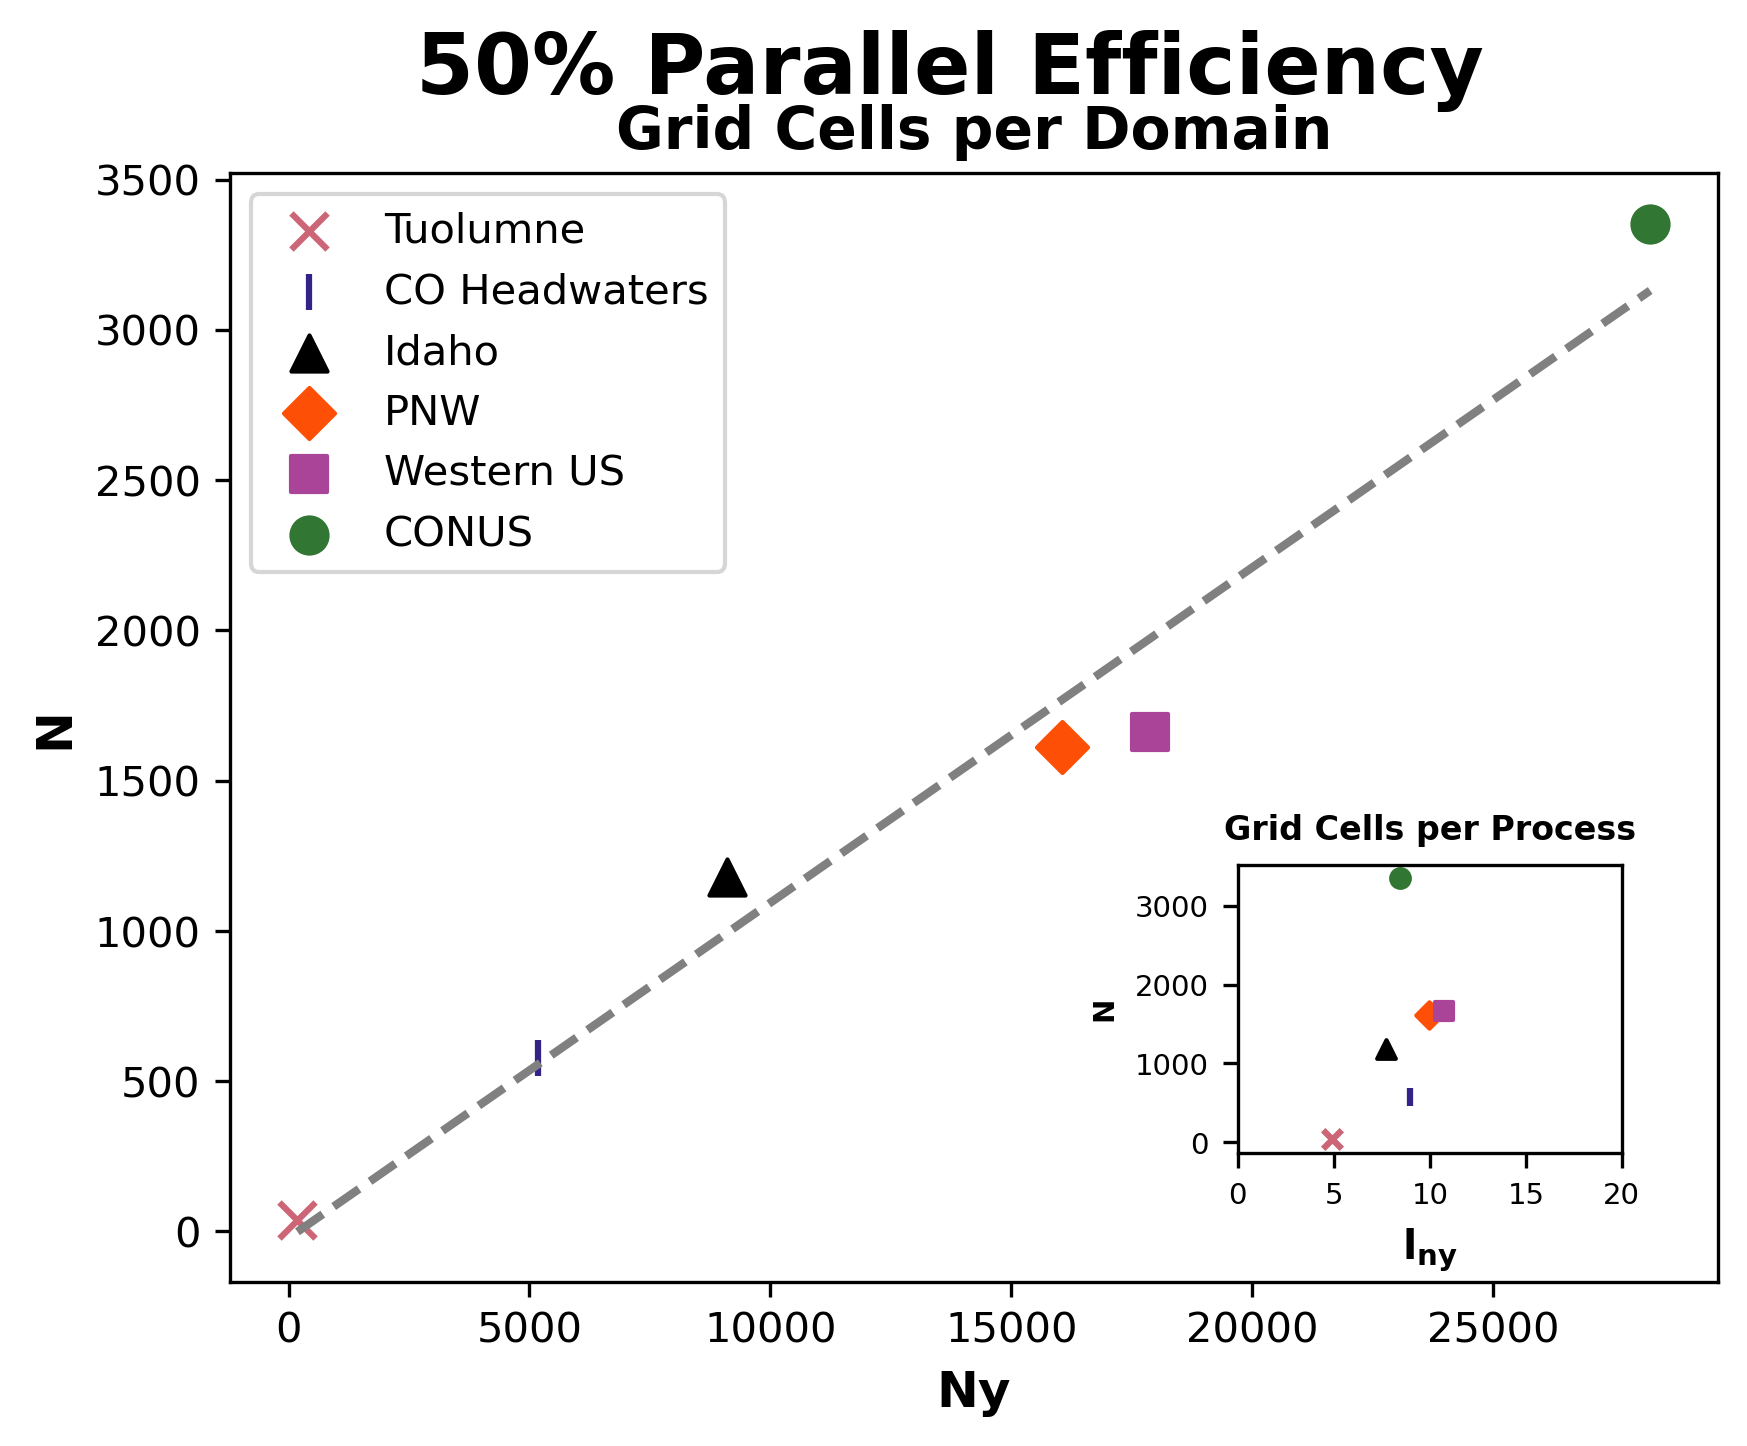

In [11]:
efficiency_v_ny(50,df_tu,df_co,df_id,df_pnw,df_west,df_conus,num_ny)